# <b> IMPORT PACKAGES </b>

In [649]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import savefig

# machine learning
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# <b>PREPARE DATA</b>

## <b> LOAD DATA </b>

   Data exported from <i>basketball-reference.com</i> were studied to understand the evolving player positions employed in this new era of small-ball basketball ushered by the 2014-2015 Golden State Warriors' death lineup. In that vein, the last three years in particular were examined, and playoff data was preferred to that of the regular season since the data would be more accurate reflections of each team's optimal rotation.

In [650]:
file_loc = 'NBA Data/NBAp.csv'
df = pd.read_csv(file_loc)
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Alex Abrines\abrinal01,SG,23,OKC,5,0,16.0,1.6,4.6,...,0.0,13.3,0.1,0.0,0.1,0.033,-3.2,-3.2,-6.4,-0.1
1,2,Steven Adams\adamsst01,C,23,OKC,5,5,31.4,3.6,5.6,...,10.9,10.0,0.3,0.1,0.4,0.116,-2.2,4.0,1.7,0.1
2,3,LaMarcus Aldridge\aldrila01,PF,31,SAS,16,16,33.6,6.9,15.0,...,9.6,24.1,0.2,0.4,0.6,0.058,-2.7,1.4,-1.3,0.1
3,4,Lavoy Allen\allenla01,PF,27,IND,3,0,3.7,0.0,0.0,...,100.0,4.0,0.0,0.0,0.0,-0.145,-13.0,1.2,-11.8,0.0
4,5,Al-Farouq Aminu\aminual01,SF,26,POR,4,0,28.3,4.3,9.3,...,17.7,18.7,0.0,0.1,0.0,0.016,-4.4,4.1,-0.4,0.0


## <b> CLEAN DATA </b>

In [651]:
# Tidying the player names
for i in df['Player'].axes[0]:
    df.set_value(i, 'Player', df['Player'][i].rsplit('\\')[0])

df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Alex Abrines,SG,23,OKC,5,0,16.0,1.6,4.6,...,0.0,13.3,0.1,0.0,0.1,0.033,-3.2,-3.2,-6.4,-0.1
1,2,Steven Adams,C,23,OKC,5,5,31.4,3.6,5.6,...,10.9,10.0,0.3,0.1,0.4,0.116,-2.2,4.0,1.7,0.1
2,3,LaMarcus Aldridge,PF,31,SAS,16,16,33.6,6.9,15.0,...,9.6,24.1,0.2,0.4,0.6,0.058,-2.7,1.4,-1.3,0.1
3,4,Lavoy Allen,PF,27,IND,3,0,3.7,0.0,0.0,...,100.0,4.0,0.0,0.0,0.0,-0.145,-13.0,1.2,-11.8,0.0
4,5,Al-Farouq Aminu,SF,26,POR,4,0,28.3,4.3,9.3,...,17.7,18.7,0.0,0.1,0.0,0.016,-4.4,4.1,-0.4,0.0


Players in the data without significant contributions were eliminated to avoid distorting the results. Minutes per game was chosen as a reasonable criteria to determine a threshold to cut players.

Number of bins: 8.04377326887


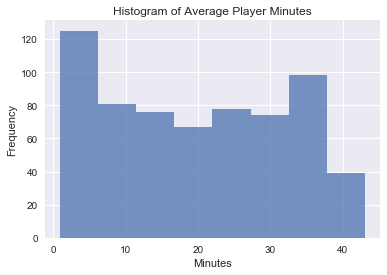

In [652]:
# Plotting the distribution of minutes

# Determine number of histogram bins using the Freedman-Diaconis rule
minutes = df['MP']
q75, q25 = np.percentile(minutes, [75, 25])
iqr = q75 - q25
n = minutes.shape[0]
h = 2 * iqr * (n ** (-1 / 3))
num_bins = (minutes.max() - minutes.min()) / h
print ("Number of bins:", num_bins)

plt.hist(df['MP'], bins = 8, alpha = 0.75);
plt.title('Histogram of Average Player Minutes');
plt.xlabel('Minutes');
plt.ylabel('Frequency');

In [653]:
# Dropping unnecessary features
df = df.drop(['Rk', 'Age', 'G', 'GS'], axis = 1)

# Dropping players who have not played at least 10 minutes per game, decided via histogram
df = df[df['MP']>10]

## <b> PRE-PROCESS DATA </b>

Both basic statistics (e.g. 3P, STL, AST, etc.) and some advanced statistics (e.g. AST%, OBPM%, DWS, etc.) were used as input features. The effect of the redundancy between features was minimized by the dimensionality reduction applied before clustering; however, linearly dependent features (e.g. TRB, 3P%, DRB%, etc.) were nonetheless omitted. 

In [654]:
# Choosing desired features
# Note: disregarding linearly dependent features (e.g. including ORB and DRB but not TRB)
X = df[['FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'AST',
 'STL', 'BLK', 'TOV', 'PF', 'PTS', '3PAr', 'FTr', 'AST%', 'STL%', 'BLK%', 'TOV%','OBPM','DBPM','OWS','DWS']] # features

X.head()

,FG,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,DRB,...,3PAr,FTr,AST%,STL%,BLK%,TOV%,OBPM,DBPM,OWS,DWS
0,1.6,4.6,1.0,3.4,0.6,1.2,0.6,0.8,0.4,1.4,...,0.739,0.174,7.1,0.0,0.0,0.0,-3.2,-3.2,0.1,0.0
1,3.6,5.6,0.0,0.0,3.6,5.6,0.8,2.2,3.4,3.4,...,0.000,0.393,6.5,1.9,5.5,10.9,-2.2,4.0,0.3,0.1
2,6.9,15.0,0.1,0.9,6.8,14.1,2.6,3.4,2.7,4.8,...,0.058,0.229,7.2,1.0,2.9,9.6,-2.7,1.4,0.2,0.4
4,4.3,9.3,1.8,4.3,2.5,5.0,1.8,2.8,1.3,5.3,...,0.459,0.297,6.0,1.2,3.0,17.7,-4.4,4.1,0.0,0.1
5,2.4,4.3,0.2,0.7,2.2,3.6,0.5,0.7,0.8,2.3,...,0.156,0.172,20.1,2.6,1.0,9.2,2.2,3.1,0.5,0.2


In [655]:
# Filling in NaN values with 0 (e.g. for players who do not shoot 3P)
X = X.fillna(value = 0);

In [656]:
# Mean normalization
# Distribution mean equals 0; variance equals 1
X_norm = (X - X.mean()) / X.std()

# <b>DIMENSIONALITY REDUCTION</b>

## <b>PRINCIPAL COMPONENT ANALYSIS</b>

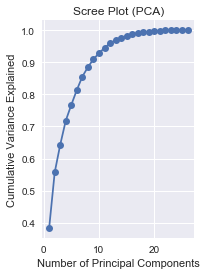

In [657]:
# Examining the scree plot to determine optimal number of dimensions
pca_plt = PCA()
pca_plt.fit(X_norm)
pca_var = pca_plt.explained_variance_ratio_
pca_tot_var = np.array([sum(pca_var[0:i+1]) for i,x in enumerate(pca_var)])

plt.subplot(121)
plt.plot(range(1,len(pca_tot_var)+1),pca_tot_var,'-o');
plt.xlabel('Number of Principal Components');
plt.ylabel('Cumulative Variance Explained');
plt.title('Scree Plot (PCA)');

In [658]:
pca = PCA(n_components = 8)
pca.fit(X_norm);
print ("Variance explained with", pca.n_components, "principal components:", sum(pca.explained_variance_ratio_))

Variance explained with 8 principal components: 0.884876159258


The scree plot shows that eight principal components should be used, explaining approximately 88% of the variance.

## <b> LINEAR DISCRIMINANT ANALYSIS </b>

The LDA algorithm was trained against the traditional NBA positions, looking for a feature subspace that maximized the separation between those five old positions.

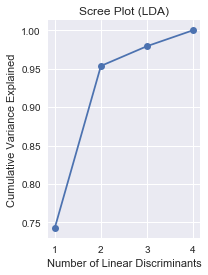

In [659]:
# Examining the scree plot to determine optimal number of dimensions

# Traditional positions used as classes for LDA
Y = df['Pos']

lda_plt = LinearDiscriminantAnalysis()
lda_plt.fit(X_norm, Y)
var = lda_plt.explained_variance_ratio_
tot_var = np.array([sum(var[0:i+1]) for i,x in enumerate(var)])

plt.subplot(121)
plt.plot(range(1,len(tot_var)+1),tot_var,'-o');
plt.xlabel('Number of Linear Discriminants');
plt.ylabel('Cumulative Variance Explained');
plt.title('Scree Plot (LDA)');

Two linear discriminants appeared to be optimal, which also made visualization more convenient. A quick comparison between the two scree plots made evident that LDA yielded better dimensionality reduction results than PCA, retaining a greater amount of variance with fewer eigenvectors. Explaining 95% of the variance with two linear discriminants was more than reasonable. 

In [660]:
# Running LDA

# Traditional positions used as classes for LDA
Y = df['Pos']

# LDA with two components
lda = LinearDiscriminantAnalysis(n_components = 2)
lda.fit(X_norm, Y)
X_lda = lda.transform(X_norm)

In [661]:
# Variance explained
print ("Variance explained with", lda.n_components, "linear discriminants:", sum(lda.explained_variance_ratio_))

Variance explained with 2 linear discriminants: 0.953546728374


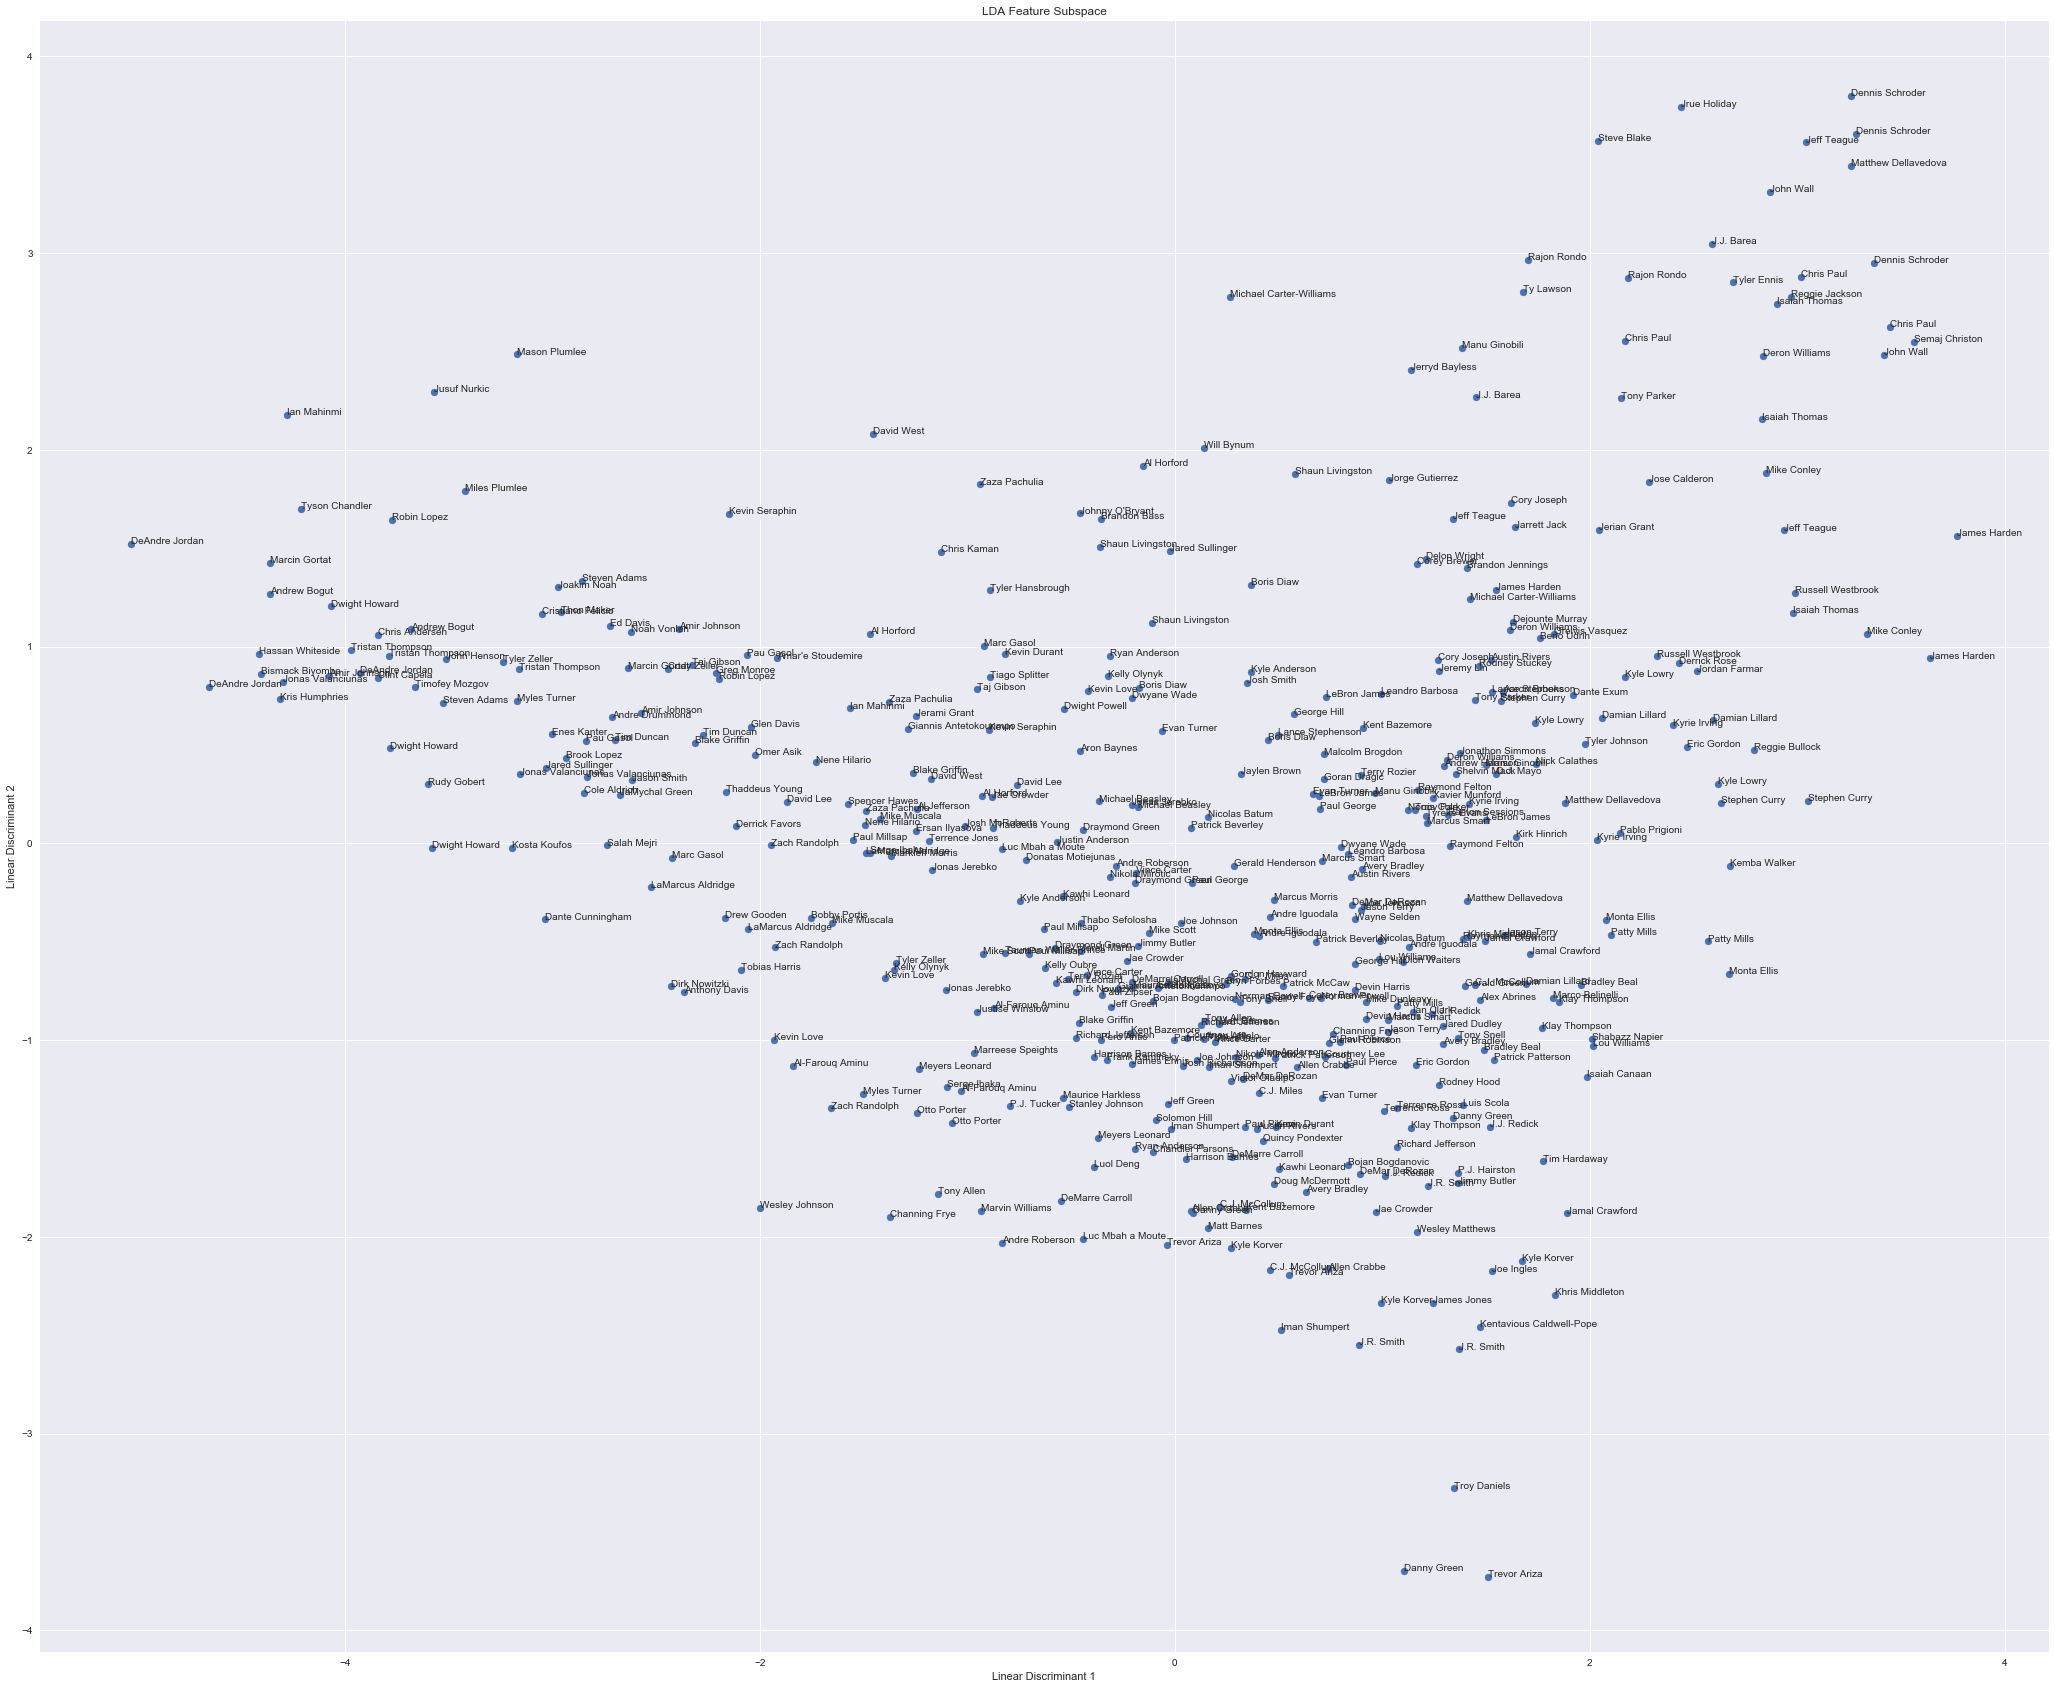

In [706]:
# Visualizing the distribution of players with a scatter plot
fig, ax = plt.subplots(figsize = (36,30))

plot_x = X_lda[:,0]
plot_y = X_lda[:,1]
ax.scatter(plot_x, plot_y)

# Labeling each data point with the player name
names = df['Player']
for i, j in enumerate(names):
    ax.annotate(j, (plot_x[i], plot_y[i]))

plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.title('LDA Feature Subspace')
    
# Saving plot to file
savefig('2DReduced.pdf')

# <b>CREATING CLUSTERS</b>

## <b> DBSCAN CLUSTERING </b>

An attempt to use DBSCAN clustering was made, hoping to take advantage of its ability to find more arbitarily shaped clusters as well as its robustness to noise.

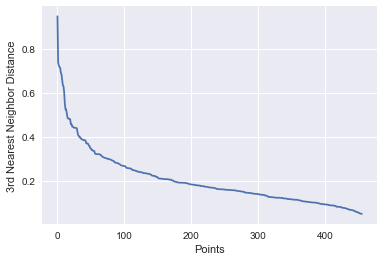

In [663]:
# Using a k-distance graph to determine epsilon
nbrs = NearestNeighbors(n_neighbors = 3).fit(X_lda)

distances, indices = nbrs.kneighbors(X_lda)
plt.plot(sorted(distances[:,2], reverse = True));
plt.xlabel('Points');
plt.ylabel('3rd Nearest Neighbor Distance');

# Epsilon = 0.3 seems reasonable--at the knee of the graph

In [664]:
# Running DBSCAN
dbscan = DBSCAN(eps = 0.3, min_samples = 3)
dbscan.fit(X_lda)
dbscan.labels_[:50]

array([ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0, -1,  2,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        3,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  3,  0, -1,  0])

Simply examining the first fifty DBSCAN labels revealed that the algorithm did not work as well as hoped with many underpopulated clusters and also important players considered to be noise. It was possible that DBSCAN struggled to create meaningful clusters because of the uniformity of the data.

## <b> <i>K</i>-MEANS CLUSTERING </b>

The next algorithm attempted was <i>k</i>-means clustering.

In [665]:
# Generating the silhouette scores for a range of k-means clusters
scores = []
for i in range(2,15):
    kmeans_plt = KMeans(n_clusters = i, n_init = 100, max_iter = 1000)
    kmeans_plt.fit(X_lda)
    predict = kmeans_plt.predict(X_lda)
    scores.append(silhouette_score(X_lda, predict))

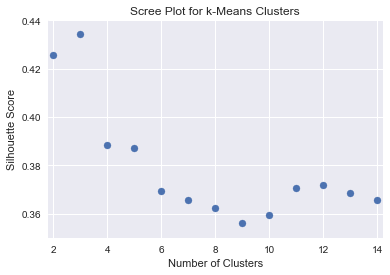

In [666]:
# Creating a scree plot to determine the number of clusters
fig_ss, ax_ss = plt.subplots()
x_ss = list(range(2,15))
y_ss = scores
ax_ss.scatter(x_ss, y_ss)
ax_ss.axis([1.8, 14.2, .35, .44]);
plt.xlabel('Number of Clusters');
plt.ylabel('Silhouette Score');
plt.title('Scree Plot for k-Means Clusters');

Using five clusters did not seem unreasonable, and it would retain its greater meaning in the context of basketball. Also, while using fewer clusters would yield a higher silhouette score (and thus slightly more separated clusters), they would also carry less significance realistically. Still, this could be explored further in the future.

In [667]:
# Running k-means
kmeans = KMeans(n_clusters = 5, n_init = 100, max_iter = 1000)
kmeans.fit(X_lda)
kmeans.cluster_centers_;

In [668]:
# Silhouette score
predict = kmeans.predict(X_lda)
print ("Silhouette score with", kmeans.n_clusters, "clusters:", silhouette_score(X_lda, predict))

Silhouette score with 5 clusters: 0.387327529804


In [669]:
# Assigning clusters
df['Cluster'] = kmeans.labels_

# <b> ANALYSIS </b>

In [670]:
# Creating data frames for the individual years for further analysis
file_loc17 = 'NBA Data/NBAp17.csv'
file_loc16 = 'NBA Data/NBAp16.csv'
file_loc15 = 'NBA Data/NBAp15.csv'

len17 = pd.read_csv(file_loc17).shape[0]
len16 = pd.read_csv(file_loc16).shape[0]
len15 = pd.read_csv(file_loc15).shape[0]

df17 = df.loc[:len17]
df16 = df.loc[len17:len17+len16]
df15 = df.loc[len17+len16:len17+len16+len15]

In [671]:
# Saving the names of the players in each cluster, separated by year
names17 = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    names17[i] = df17[df17['Cluster'] == i]['Player']

names16 = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    names16[i] = df16[df16['Cluster'] == i]['Player']

names15 = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    names15[i] = df15[df15['Cluster'] == i]['Player']

## <b>NEW POSITION STATISTICAL RANKINGS</b>

In [672]:
# New position statistical rankings
# Note: 5.0 represents the highest, 1.0 the lowest
rank_df = pd.DataFrame()
for i in range(5):
    rank_df[i] = X[df['Cluster'] == i].sum(axis = 0).divide(X[df['Cluster'] == i].shape[0])

rank_df = rank_df.drop(['2PA', '3PA', 'FGA', 'FTA', 'PTS', 'FG'])
rank_df = rank_df.transpose()

rank_df.index = ['Position 0', 'Position 1', 'Position 2',
                      'Position 3', 'Position 4']

rank_df.rank(axis = 0)

,3P,2P,FT,ORB,DRB,AST,STL,BLK,TOV,PF,3PAr,FTr,AST%,STL%,BLK%,TOV%,OBPM,DBPM,OWS,DWS
Position 0,4.0,3.0,4.0,3.0,2.0,4.0,4.0,2.0,4.0,2.0,4.0,2.0,4.0,4.0,2.0,3.0,4.0,2.0,4.0,3.0
Position 1,1.0,4.0,3.0,5.0,5.0,1.0,1.0,5.0,3.0,5.0,1.0,5.0,1.0,1.0,5.0,4.0,1.0,5.0,5.0,5.0
Position 2,3.0,5.0,5.0,2.0,1.0,5.0,5.0,1.0,5.0,3.0,3.0,3.0,5.0,5.0,1.0,5.0,5.0,1.0,3.0,1.0
Position 3,5.0,1.0,1.0,1.0,3.0,2.0,3.0,3.0,1.0,1.0,5.0,1.0,2.0,3.0,3.0,1.0,3.0,3.0,1.0,2.0
Position 4,2.0,2.0,2.0,4.0,4.0,3.0,2.0,4.0,2.0,4.0,2.0,4.0,3.0,2.0,4.0,2.0,2.0,4.0,2.0,4.0


## NEW POSITION BREAKDOWN

While the rankings were potentially affected by weaker, irrelevant players dragging down averages, combined with the list of players assigned to each position, they still provided a solid understanding of the new positions.

* <b>Position 0 (Scoring Ball-Handlers)</b>
  * Stephen Curry, LeBron James, Kyrie Irving, Tony Parker, Jamal Crawford, Al Horford, Paul George, etc. (2017)
  * The offense often has these players handling the ball, though scoring remains their primary focus unlike Position 2
  * Rank 2nd in 3P, FT, AST, TOV, 3PAr, AST%, STL%, OBPM, OWS
<br><br>
* <b>Position 1 (Traditional Big Men)</b>
  * DeAndre Jordan, Derrick Favors, Tristan Thompson, Steven Adams, Greg Monroe, Jonas Valanciunas, Dwight Howard, etc. (2017)
  * These big men spend most of their time around the rim, whether scoring or defending
  * Rank the highest in PF, ORB, DRB, BLK, FTr, BLK%, DBPM, OWS, and DWS
<br><br>
* <b>Position 2 (Floor Generals)</b>
  * Chris Paul, John Wall, Isaiah Thomas, Dennis Schroder, James Harden, Mike Conley, Rajon Rondo, etc. (2017)
  * These are the elite playmakers who elicit full control of the offenses that they run
  * Rank highest in AST, AST%, STL, STL%, 2P, TOV, TOV%, and OBPM--also USG%
<br><br>
* <b>Position 3 (Three-And-D/Three-Point Specialists)</b>
  * Klay Thompson, J.J. Redick, Avery Bradley, J.R. Smith, Andre Iguodala, Kyle Korver, Ryan Anderson, Nikola Mirotic, etc. (2017)
  * They space the floor with the three-pointer as their primary weapon; defense is also a specialty of many of these players
  * Rank the highest in 3P, 3PAr; 3rd in STL, BLK, STL%, and BLK%
<br><br>
* <b>Position 4 (Versatile Two-Ways)</b>
  * Kawhi Leonard, Draymond Green, Jimmy Butler, Marc Gasol, Kevin Durant, Giannis Antetokounmpo, Andre Roberson, etc. (2017)
  * They are all-around players who operate meaningfully on both ends of the court
  * Rank 2nd in ORB, DRB, BLK, FTr, BLK%, DBPM; 3rd in AST, AST%



Note: The example players for each position were chosen from 2017 because they are easier to relate to for the average NBA fan, being fresher in our minds.

## <b>DISTRIBUTION OF TRADITIONAL POSITIONS IN NEW POSITIONS</b>

A skim of the list of names in each position quickly evinced that most of the new positions consist of players from a varied distribution of old positions, suggesting that at the least, for better or for worse, this process has provided a valid altered perspective at examining players' roles on the court. 

In [673]:
# Seeing how old positions fit into new positions
positions17 = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    positions17[i] = df17[df17['Cluster'] == i]['Pos']


positions16 = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    positions16[i] = df16[df16['Cluster'] == i]['Pos']


positions15 = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    positions15[i] = df15[df15['Cluster'] == i]['Pos']

In [674]:
# 2017 old position distribution relative to the new positions
position_df17 = pd.DataFrame()

position_df17['Total number of players'] = [len(positions17[i]) for i in range(5)]    
position_df17['Number of PG:'] = [list(positions17[i]).count('PG') for i in range(5)]
position_df17['Number of SG:'] = [list(positions17[i]).count('SG') for i in range(5)]
position_df17['Number of SF:'] = [list(positions17[i]).count('SF') for i in range(5)]
position_df17['Number of PF:'] = [list(positions17[i]).count('PF') for i in range(5)]
position_df17['Number of C:'] = [list(positions17[i]).count('C') for i in range(5)]

position_df17.index = ['Position 0 (2017)', 'Position 1 (2017)', 'Position 2 (2017)',
                      'Position 3 (2017)', 'Position 4 (2017)']

position_df17

,Total number of players,Number of PG:,Number of SG:,Number of SF:,Number of PF:,Number of C:
Position 0 (2017),36,19,9,6,1,1
Position 1 (2017),22,0,0,0,4,18
Position 2 (2017),11,11,0,0,0,0
Position 3 (2017),49,2,27,15,4,1
Position 4 (2017),40,1,1,15,16,7


In [675]:
# 2016 old position distribution relative to the new positions
position_df16 = pd.DataFrame()

position_df16['Total number of players'] = [len(positions16[i]) for i in range(5)]    
position_df16['Number of PG:'] = [list(positions16[i]).count('PG') for i in range(5)]
position_df16['Number of SG:'] = [list(positions16[i]).count('SG') for i in range(5)]
position_df16['Number of SF:'] = [list(positions16[i]).count('SF') for i in range(5)]
position_df16['Number of PF:'] = [list(positions16[i]).count('PF') for i in range(5)]
position_df16['Number of C:'] = [list(positions16[i]).count('C') for i in range(5)]

position_df16.index = ['Position 0 (2016)', 'Position 1 (2016)', 'Position 2 (2016)',
                      'Position 3 (2016)', 'Position 4 (2016)']

position_df16

,Total number of players,Number of PG:,Number of SG:,Number of SF:,Number of PF:,Number of C:
Position 0 (2016),28,11,11,4,2,0
Position 1 (2016),23,0,0,0,6,17
Position 2 (2016),13,12,1,0,0,0
Position 3 (2016),44,3,19,19,3,0
Position 4 (2016),41,2,2,10,20,7


In [676]:
# 2015 old position distribution relative to the new positions
position_df15 = pd.DataFrame()

position_df15['Total number of players'] = [len(positions15[i]) for i in range(5)]    
position_df15['Number of PG:'] = [list(positions15[i]).count('PG') for i in range(5)]
position_df15['Number of SG:'] = [list(positions15[i]).count('SG') for i in range(5)]
position_df15['Number of SF:'] = [list(positions15[i]).count('SF') for i in range(5)]
position_df15['Number of PF:'] = [list(positions15[i]).count('PF') for i in range(5)]
position_df15['Number of C:'] = [list(positions15[i]).count('C') for i in range(5)]

position_df15.index = ['Position 0 (2015)', 'Position 1 (2015)', 'Position 2 (2015)',
                      'Position 3 (2015)', 'Position 4 (2015)']

position_df15

,Total number of players,Number of PG:,Number of SG:,Number of SF:,Number of PF:,Number of C:
Position 0 (2015),34,19,13,1,1,0
Position 1 (2015),25,0,0,0,9,16
Position 2 (2015),12,11,1,0,0,0
Position 3 (2015),34,2,17,14,1,0
Position 4 (2015),45,1,6,8,21,9


<b>Quick Observations:</b>

The Floor Generals position consisted almost purely of point guards, while the Traditional Big Men position included only power forwards and centers. Meanwhile, the Three-And-D position had a solid mix between shooting guards and small forwards. 

The Scoring Ball-Handlers position consisted of more and more small forwards over the years, including additions such as Paul George. 

The total number of Traditional Big Men decreased from 25 (2015) to 23 (2016) to 22 (2017).

## <b>POSITION CHANGES BETWEEN THE YEARS</b>

<b>Russell Westbrook:</b> Scoring Ball-Handler (2017), Floor General (2016)

<b>Kevin Durant:</b> Versatile Two-Way (2017), Three-And-D (2016)

<b>Kawhi Leonard:</b> Versatile Two-Way (2017), Three-And-D (2016)

<b>DeMar DeRozan:</b> Three-And-D (2016-17), Scoring Ball-Handler (2015)

<b>James harden:</b> Floor General (2016-17), Scoring Ball-Handler (2015)

<i>To be continued...</i>

In [686]:
names17[0];

## <b>A LOOK AT THE FINALS LINEUPS</b>

<b>GOLDEN STATE WARRIORS</b>

In [678]:
# Investigating the team composition of GSW
gsw = pd.DataFrame()
gsw_list17 = list()
gsw_list16 = list()
gsw_list15 = list()

tm_index17 = df17[df17['Tm'] == 'GSW'].index.tolist()
for i in tm_index17:
    if (df17.loc[i]['MP']>10):
        gsw_list17.append(df17.loc[i]['Player'] + ": " + str(df17.loc[i]['Cluster']))
        #print (df17.loc[i]['Player'], df17.loc[i]['Cluster'])

tm_index16 = df16[df16['Tm'] == 'GSW'].index.tolist()
for i in tm_index16:
    if (df16.loc[i]['MP']>10):
        gsw_list16.append(df16.loc[i]['Player'] + ": " + str(df16.loc[i]['Cluster']))

tm_index15 = df15[df15['Tm'] == 'GSW'].index.tolist()
for i in tm_index15:
    if (df15.loc[i]['MP']>10):
        gsw_list15.append(df15.loc[i]['Player'] + ": " + str(df15.loc[i]['Cluster']))

gsw['2017'] = pd.Series(gsw_list17)
gsw['2016'] = pd.Series(gsw_list16)
gsw['2015'] = pd.Series(gsw_list15)

gsw

,2017,2016,2015
0,Ian Clark: 3,Leandro Barbosa: 0,Leandro Barbosa: 0
1,Stephen Curry: 0,Harrison Barnes: 3,Harrison Barnes: 4
2,Kevin Durant: 4,Andrew Bogut: 1,Andrew Bogut: 1
3,Draymond Green: 4,Stephen Curry: 0,Stephen Curry: 0
4,Andre Iguodala: 3,Draymond Green: 4,Draymond Green: 4
5,Shaun Livingston: 4,Andre Iguodala: 3,Andre Iguodala: 3
6,Patrick McCaw: 3,Shaun Livingston: 0,Shaun Livingston: 4
7,Zaza Pachulia: 4,Klay Thompson: 3,Klay Thompson: 3
8,Klay Thompson: 3,NaN,NaN
9,David West: 1,NaN,NaN


The birth of the death lineup came when Steve Kerr replaced Andrew Bogut, a Traditional Big Man, with Andre Iguodala, a Three-And-D player, in the 2015 NBA finals. Its efficacy was on full display when the Warriors clinched the 4-2 finals win over the Cavaliers with Andre Iguodala being named the Finals MVP. 

While the 2017 death lineup was only used for seventeen minutes in this year's finals before Game 5, many of the Warriors' lineups still incorporated the small ball style, incorporating players such as Patrick McCaw and Shaun Livingston. Then, in Game 5, Steve Kerr played the death lineup for sixteen minutes leading to the finals victory.

It is also interesting to note that none of the Warriors espoused that true floor general role; rather, they operated with a fluid offensive system with multiple players initating plays. Mostly, they had Stephen Curry as the Scoring Ball-Handler and then a combination of Three-And-D players and Versatile Two-Ways. 

The lineup plus-minuses and net ratings have been included for reference. 

<b>Golden State's Lineups:</b>

| 2017 | 2017 Death Lineup | 2016 Death Lineup | 2015 Death Lineup |
| :--- | :--- | :--- | :--- |
| Stephen Curry (Scoring Ball-Handler) | Stephen Curry (Scoring Ball-Handler) | Stephen Curry (Scoring Ball-Handler)| Stephen Curry (Scoring Ball-Handler) |
| Klay Thompson (Three-And-D) | Klay Thompson (Three-And-D) | Klay Thompson (Three-And-D) | Klay Thompson (Three-And-D) |
| Kevin Durant (Versatile Two-Way) | Kevin Durant (Versatile Two-Way) | Harrison Barnes (Three-And-D) | Harrison Barnes (Versatile Two-Way) |
| Draymond Green (Versatile Two-Way) | Draymond Green (Versatile Two-Way) | Draymond Green (Versatile Two-Way) | Draymond Green (Versatile Two-Way) |
| Zaza Pachulia (Versatile Two-Way) | Andre Iguodala (Three-And-D) | Andre Iguodala (Three-And-D) | Andre Iguodala (Three-And-D) |

| | 2017| 2017 Death Lineup | 2016 Death Lineup | 2015 Death Lineup |
| :--- | :---: | :---: | :---:| :---: |
| +/- | 4.1 | 2.8 | -0.3 | 2.4 |
| NETRTG | 15.7 | 32.9 | -5.3 | 15.7 |

<b>CLEVELAND CAVALIERS</b>

In [690]:
# Investigating the team composition of CLE
cle = pd.DataFrame()
cle_list17 = list()
cle_list16 = list()
cle_list15 = list()

tm_index17 = df17[df17['Tm'] == 'CLE'].index.tolist()
for i in tm_index17:
    if (df17.loc[i]['MP']>10):
        cle_list17.append(df17.loc[i]['Player'] + ": " + str(df17.loc[i]['Cluster']))

tm_index16 = df16[df16['Tm'] == 'CLE'].index.tolist()
for i in tm_index16:
    if (df16.loc[i]['MP']>10):
        cle_list16.append(df16.loc[i]['Player'] + ": " + str(df16.loc[i]['Cluster']))

tm_index15 = df15[df15['Tm'] == 'CLE'].index.tolist()
for i in tm_index15:
    if (df15.loc[i]['MP']>10):
        cle_list15.append(df15.loc[i]['Player'] + ": " + str(df15.loc[i]['Cluster']))

cle['2017'] = pd.Series(cle_list17)
cle['2016'] = pd.Series(cle_list16)
cle['2015'] = pd.Series(cle_list15)

cle

,2017,2016,2015
0,Channing Frye: 3,Matthew Dellavedova: 2,Matthew Dellavedova: 0
1,Kyrie Irving: 0,Channing Frye: 4,Kyrie Irving: 0
2,LeBron James: 0,Kyrie Irving: 0,LeBron James: 0
3,Richard Jefferson: 3,LeBron James: 0,James Jones: 3
4,Kyle Korver: 3,Richard Jefferson: 4,Kevin Love: 4
5,Kevin Love: 4,Kevin Love: 4,Timofey Mozgov: 1
6,Iman Shumpert: 3,Iman Shumpert: 3,Iman Shumpert: 3
7,J.R. Smith: 3,J.R. Smith: 3,J.R. Smith: 3
8,Tristan Thompson: 1,Tristan Thompson: 1,Tristan Thompson: 1
9,Deron Williams: 0,NaN,NaN


On the other hand, the Cleveland Cavaliers opted to use a bigger lineup to try to counter the Warriors' small ball style of play--as shown by the usage of Traditional Big Men in the lineups. Still, Timofey Mozgov fell out of the starting lineup with the return of Kevin Love and instead, the Cavs employed a lineup with greater spacing and less at-the-rim play. 

<b>Cleveland's Most Played Lineup:</b>

|2017 | 2016 | 2015|
| :--- | :--- | :--- |
| Kyrie Irving (Scoring Ball-Handler) | Kyrie Irving (Scoring Ball-Handler)| Kyrie Irving (Scoring Ball-Handler) |
| J.R. Smith (Three-And-D) | J.R. Smith (Three-And-D) | Iman Shumpert (Three-And-D) |
| LeBron James (Scoring Ball-Handler) | LeBron James (Scoring Ball-Handler) | LeBron James (Scoring Ball-Handler) |
| Kevin Love (Versatile Two-Way) | Kevin Love (Versatile Two-Way) | Tristan Thompson (Traditional Big Man) |
| Tristan Thompson (Traditional Big Man) | Tristan Thompson (Traditional Big Man) | Timofey Mozgov (Traditional Big Man) |

| | 2017 | 2016 | 2015 |
| :---: | :---: | :---:| :---: |
| +/- | 3.6 | 6.5 | 1.7 |
| NETRTG | 10.2 | 18.5 | 8.2 |

## <b>EXAMINING A FEW OTHER TEAMS' 2017 PLAYOFF LINEUPS</b>

<b>WASHINGTON WIZARDS, BOSTON CELTICS, OKLAHOMA CITY THUNDER, TORONTO RAPTORS</b>

The lineups are from [stats.nba.com/lineups](stats.nba.com/lineups).

<b>Lineup Comparisons:</b>

| Washington Wizards | Boston Celtics | Oklahoma City Thunder | Toronto Raptors |
| :--- | :--- | :--- | :--- | 
| Bradley Beal (Scoring Ball-Handler) | Avery Bradley (Three-And-D) | Steven Adams (Traditional Big Man) | DeMar DeRozan (Three-And-D) |
| Marcin Gortat (Traditional Big Man) | Jae Crowder (Versatile Two-Way) | Taj Gibson (Versatile Two-Way) | Serge Ibaka (Versatile Two-Way) |
| Markieff Morris (Versatile Two-Way) | Jonas Jerebko (Versatile Two-Way) | Victor Oladipo (Three-And-D) | DeMarre Carroll (Three-And-D) |
| Otto Porter (Versatile Two-Way) | Kelly Olynyk (Versatile Two-Way) | Andre Roberson (Versatile Two-Way) | Kyle Lowry (Scoring Ball-Handler) |
| John Wall (Floor General) | Marcus Smart (Scoring Ball-Handler) | Russell Westbrook (Scoring Ball-Handler) | Normal Powell (Three-And-D) |

| | WAS | BOS | OKC | TOR |
| --- | :---:| :---: | :---: | :---: |
| +/- | 8.0 | 7.0 | 6.4 | 5.3 |
| NETRTG | 18.0 | 86.9 | 21.2 | 17.4 |

Observing these top lineups from 2017 (based on plus-minus), none of them ran two Traditional Big Men at a time; in fact, two of them did not include one at all, bolstering the claim for the general shift towards small ball basketball. 

Note: More lineups should be studied in the future with the potential for deeper and more structured analysis.

## <b>ADVANCED STATISTICS EXPLORATION</b>

<b>WIN SHARES</b>

In [680]:
# Exploring win shares per new position
# Using median (as opposed to mean) for robustness
ws_df = pd.DataFrame()

win_shares = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    win_shares[i] = df[df['Cluster'] == i]['WS']
    
o_win_shares = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    o_win_shares[i] = df[df['Cluster'] == i]['OWS']

d_win_shares = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    d_win_shares[i] = df[df['Cluster'] == i]['DWS']

win_shares_48 = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    win_shares_48[i] = df[df['Cluster'] == i]['WS/48']
    
ws_df['Median Win Shares'] = [np.percentile(win_shares[i], [50])[0] for i in range(5)]
ws_df['Median Off Win Shares'] = [np.percentile(o_win_shares[i], [50])[0] for i in range(5)]
ws_df['Median Def Win Shares'] = [np.percentile(d_win_shares[i], [50])[0] for i in range(5)]
ws_df['Median Win Shares Per 48'] = [np.percentile(win_shares_48[i], [50])[0] for i in range(5)]

ws_df.index = ['Position 0', 'Position 1', 'Position 2',
                      'Position 3', 'Position 4']

ws_df

,Median Win Shares,Median Off Win Shares,Median Def Win Shares,Median Win Shares Per 48
Position 0,0.30,0.1,0.2,0.0725
Position 1,0.50,0.3,0.3,0.1280
Position 2,0.25,0.2,0.1,0.0810
Position 3,0.30,0.1,0.2,0.0600
Position 4,0.30,0.1,0.2,0.0860


<b>VALUE OVER REPLACEMENT PLAYER</b>

In [704]:
# Exploring Value Over Replacement Player per new position
vorp_df = pd.DataFrame()

vorp = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    vorp[i] = df[df['Cluster'] == i]['VORP']
    
bpm = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    bpm[i] = df[df['Cluster'] == i]['BPM']
    
obpm = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    obpm[i] = df[df['Cluster'] == i]['OBPM']

dbpm = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    dbpm[i] = df[df['Cluster'] == i]['DBPM']
    
vorp_df['Median VORP'] = [np.percentile(vorp[i], [50])[0] for i in range(5)]
vorp_df['Mean VORP'] = [np.mean(vorp[i]) for i in range(5)]
vorp_df['VORP Standard Deviation'] = [np.std(vorp[i]) for i in range(5)]
vorp_df['Median BPM'] = [np.percentile(bpm[i], [50])[0] for i in range(5)]
vorp_df['Median OBPM'] = [np.percentile(obpm[i], [50])[0] for i in range(5)]
vorp_df['Median DBPM'] = [np.percentile(dbpm[i], [50])[0] for i in range(5)]

vorp_df.index = ['Position 0', 'Position 1', 'Position 2',
                      'Position 3', 'Position 4']

vorp_df

,Median VORP,Mean VORP,VORP Standard Deviation,Median BPM,Median OBPM,Median DBPM
Position 0,0.1,0.292857,0.606302,0.05,-0.30,0.4
Position 1,0.2,0.247826,0.292222,1.50,-1.70,3.3
Position 2,0.1,0.247222,0.484473,0.40,1.15,-0.4
Position 3,0.1,0.192126,0.312371,-0.10,-1.10,0.8
Position 4,0.1,0.193651,0.360719,0.05,-1.70,1.9


<b>USAGE%</b>

In [682]:
usg_df = pd.DataFrame()

usg = [[0 for x in range(0)] for y in range(5)]
for i in range(5):
    usg[i] = df[df['Cluster'] == i]['USG%']

usg_df['Median USG%'] = [np.percentile(usg[i], [50])[0] for i in range(5)]

usg_df.index = ['Position 0', 'Position 1', 'Position 2',
                      'Position 3', 'Position 4']

usg_df

,Median USG%
Position 0,21.00
Position 1,16.00
Position 2,24.65
Position 3,15.60
Position 4,17.70


Interestingly, the Traditional Big Man position reigns supreme in terms of median win shares and median value over replacement player, while it ranks penultimately in terms of median usage percentage. This suggests that while many teams are electing to no longer use Traditional Big Men in their primary lineups, having a strong one may actually be even more impactful. With most big men expanding their range with the three-point shot and floor spacing becoming increasingly attractive, perhaps the emergence of an inside banger similar to Shaquille  O'Neal or even Tim Duncan would see amplified dominance in this new era.

# <b>FUTURE DIRECTIONS</b>

In terms of future directions, case studies could be done on players who fit the traditional big man portfolio (e.g. Hassan Whiteside) to explore their changing role. Also, predictive models could be developed for various measurements of team success, maybe using these newly defined positions as labels. As mentioned before, more in-depth analysis of lineups should be done, as well as repeating the process for regular season data. The number of clusters could be varied, and an automated approach to tracking players who change position across years could be implemented. Overall, this project was meant to be a simple exploration of a different perspective to view NBA positions, so hopefully, it has provided some valuable insight in one way or another.

# <b>RELEVANT FORMULAS</b>

| Statistic | Description | Formula |
| :--- | :--- | :--- |
| AST% | Estimates the percentage of field goals that the player assisted | $= \frac{100\cdot\text{AST}}{\frac{5\cdot\text{MP}\cdot\text{Tm FG}}{\text{Tm MP}}-\text{FG}}$ |
| BLK% | Estimates the percentae of opponent 2PA are blocked by the player | $= \frac{20\cdot\text{BLK}\cdot\text{Tm MP}}{MP(\text{Opp FGA}-\text{Opp 3PA})}$ |
| DRB% | Estimates the percentage of available defensive rebounds grabbed by a player | $= \frac{20\cdot\text{DRB}\cdot\text{Tm MP}}{MP(\text{Opp ORB}+\text{Tm DRB})}$ |
| ORB% | Estimates the percentage of available offensive rebounds grabbed by a player | $= \frac{20\cdot\text{ORB}\cdot\text{Tm MP}}{MP(\text{Opp DRB}+\text{Tm ORB})}$ |
| STL% | Estimates the percentage of opponent possessions that end with a steal by a player | $= \frac{100\cdot\text{STL}\cdot\frac{\text{Tm MP}}{5}}{\text{MP}\cdot\text{Opp Poss}}$ |
| BLK% | Estimates the percentage of opponent two-point field goal attempts blocked by a player | $= \frac{100\cdot\text{BLK}\cdot\frac{\text{Tm MP}}{5}}{\text{MP}(\text{Opp FGA}-\text{Opp 3PA})}$ |
| TOV% | Estimates the number of turnovers per 100 plays | $= \frac{100\cdot\text{TOV}}{\text{FGA}+0.44\cdot\text{FTA}+\text{TOV}}$ |
| BPM | Estimates the points per 100 possessions that a player contributes compared to an average player on an average team | |
| WS, OWS, DWS, and WS/48 | Measurements of team success attributed to an individual player | |
| VORP | Measures a player's contribution relative to a theoretical replacement player | $= (\text{BPM}-(-2.0))\cdot(\%\text{ of minutes played})\cdot(\frac{\text{team games}}{82})$ |
| USG% | Estimates the percentage of team plays used by a player while on the floor | $= \frac{100\cdot((\text{FGA}+0.44\cdot\text{FTA}+\text{TOV})\cdot(\frac{\text{Tm MP}}{5}))}{\text{MP}\cdot(\text{Tm FGA}+0.44\cdot\text{Tm FTA}+\text{Tm TOV})}$ |
| NETRTG | Measures a team's point differential per 100 possessions | $= \text{OFFRTG}-\text{DEFRTG}$ |